In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from metric_learn import LMNN
from ml_utils import graph
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from feature_selector import FeatureSelector, adjust_r2, calc_score
from file_loader import FileLoader

import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

/home/maciej/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [10]:
# ['o1', 'o2', 'o3', 'o4', 'o5']
fl = FileLoader(['o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'o9', 'o0'], mode='u', dim=[1, 2])

Loaded dataframe: (2157, 53)
Loaded dataframe: (2158, 1)


In [14]:
fl = FileLoader(['o3'], mode='c')

Loaded dataframe: (108, 53)


In [15]:
fl.df

PAPI_BR_CN  \
alg   run                                                              
d2_r0 -D PARAM_N_0=2581 -D PARAM_N_1=2581                   0.007696   
      -D PARAM_N_0=2788 -D PARAM_N_1=2788                   0.007575   
      -D PARAM_N_0=2981 -D PARAM_N_1=2981                   0.007548   
      -D PARAM_N_0=3162 -D PARAM_N_1=3162                   0.007535   
      -D PARAM_N_0=3333 -D PARAM_N_1=3333                   0.007546   
      -D PARAM_N_0=3495 -D PARAM_N_1=3495                   0.007499   
      -D PARAM_N_0=3651 -D PARAM_N_1=3651                   0.007569   
      -D PARAM_N_0=3800 -D PARAM_N_1=3800                   0.007535   
      -D PARAM_N_0=3944 -D PARAM_N_1=3944                   0.007584   
      -D PARAM_N_0=4082 -D PARAM_N_1=4082                   0.007538   
      -D PARAM_N_0=4216 -D PARAM_N_1=4216                   0.007536   
      -D PARAM_N_0=4346 -D PARAM_N_1=4346                   0.007524   
      -D PARAM_N_0=4472 -D PARAM_N_1=4472                   0.007554   
      -D PARAM_N_0=4594 -D PARAM_N_1=4594                   0.007549   
      -D PARAM_N_0=4714 -D PARAM_N_1=4714                   0.007536   
d2_r1 -D PARAM_N_0=2357 -D PARAM_N_1=2357                   0.007571   
      -D PARAM_N_0=2581 -D PARAM_N_1=2581                   0.007513   
      -D PARAM_N_0=2788 -D PARAM_N_1=2788                   0.007554   
      -D PARAM_N_0=2981 -D PARAM_N_1=2981                   0.007510   
      -D PARAM_N_0=3162 -D PARAM_N_1=3162                   0.007639   
      -D PARAM_N_0=3333 -D PARAM_N_1=3333                   0.007535   
      -D PARAM_N_0=3495 -D PARAM_N_1=3495                   0.007633   
      -D PARAM_N_0=3651 -D PARAM_N_1=3651                   0.007521   
      -D PARAM_N_0=3800 -D PARAM_N_1=3800                   0.007693   
      -D PARAM_N_0=3944 -D PARAM_N_1=3944                   0.007431   
      -D PARAM_N_0=4082 -D PARAM_N_1=4082                   0.007404   
      -D PARAM_N_0=4216 -D PARAM_N_1=4216                   0.007662   
      -D PARAM_N_0=4346 -D PARAM_N_1=4346                   0.007494   
      -D PARAM_N_0=4472 -D PARAM_N_1=4472                   0.007608   
      -D PARAM_N_0=4594 -D PARAM_N_1=4594                   0.007910   
...                                                              ...   
d3_r0 -D PARAM_N_0=158 -D PARAM_N_1=158 -D PARAM_N_2=158    0.001922   
      -D PARAM_N_0=163 -D PARAM_N_1=163 -D PARAM_N_2=163    0.001973   
      -D PARAM_N_0=168 -D PARAM_N_1=168 -D PARAM_N_2=168    0.001983   
      -D PARAM_N_0=172 -D PARAM_N_1=172 -D PARAM_N_2=172    0.001973   
      -D PARAM_N_0=176 -D PARAM_N_1=176 -D PARAM_N_2=176    0.001940   
      -D PARAM_N_0=180 -D PARAM_N_1=180 -D PARAM_N_2=180    0.001981   
      -D PARAM_N_0=183 -D PARAM_N_1=183 -D PARAM_N_2=183    0.001972   
      -D PARAM_N_0=187 -D PARAM_N_1=187 -D PARAM_N_2=187    0.001983   
      -D PARAM_N_0=190 -D PARAM_N_1=190 -D PARAM_N_2=190    0.001978   
      -D PARAM_N_0=194 -D PARAM_N_1=194 -D PARAM_N_2=194    0.001981   
d3_r1 -D PARAM_N_0=113 -D PARAM_N_1=113 -D PARAM_N_2=113    0.002168   
      -D PARAM_N_0=122 -D PARAM_N_1=122 -D PARAM_N_2=122    0.002449   
      -D PARAM_N_0=129 -D PARAM_N_1=129 -D PARAM_N_2=129    0.002895   
      -D PARAM_N_0=136 -D PARAM_N_1=136 -D PARAM_N_2=136    0.002160   
      -D PARAM_N_0=142 -D PARAM_N_1=142 -D PARAM_N_2=142    0.002196   
      -D PARAM_N_0=148 -D PARAM_N_1=148 -D PARAM_N_2=148    0.002011   
      -D PARAM_N_0=153 -D PARAM_N_1=153 -D PARAM_N_2=153    0.001582   
      -D PARAM_N_0=158 -D PARAM_N_1=158 -D PARAM_N_2=158    0.001911   
      -D PARAM_N_0=163 -D PARAM_N_1=163 -D PARAM_N_2=163    0.002160   
      -D PARAM_N_0=168 -D PARAM_N_1=168 -D PARAM_N_2=168    0.001845   
      -D PARAM_N_0=172 -D PARAM_N_1=172 -D PARAM_N_2=172    0.002207   
      -D PARAM_N_0=176 -D PARAM_N_1=176 -D PARAM_N_2=176    0.002063   
      -D PARAM_N_0=180 -D PARAM_N_1=180 -D PARAM_N_2=180    0.002071   
      -D PARAM_N_0=183 -D 

In [11]:
fl.df.sort_values(['speedup'])['speedup']

alg                                             run                               
lore_b38996ea-1dfb-4960-8f81-eb559af5d62f_42    -D PARAM_N=7071                       0.667221
lore_071e0363-89a9-4aac-9f74-05b0f47c1098_427   -D PARAM_W=57734 -D PARAM_H=57734     0.731596
                                                -D PARAM_W=40824 -D PARAM_H=40824     0.732772
lore_9b4fb134-4141-4799-8ffd-2bb4ec979288_365   -D PARAM_W=57734 -D PARAM_H=57734     0.733517
lore_f86801b9-79fa-4198-8efc-96099b09dc78_581   -D PARAM_W=57734 -D PARAM_H=57734     0.734608
lore_45b5111a-30d1-414a-ac0a-5c58f1d51f37_502   -D PARAM_W=57734 -D PARAM_H=57734     0.736453
                                                -D PARAM_W=40824 -D PARAM_H=40824     0.736567
lore_9b4fb134-4141-4799-8ffd-2bb4ec979288_365   -D PARAM_W=40824 -D PARAM_H=40824     0.736919
lore_8fe11be2-f2d0-45c8-b720-de3cde6b169d_378   -D PARAM_CCOUNT=50000000              0.737535
lore_f86801b9-79fa-4198-8efc-96099b09dc78_581   -D PARAM_W=408

In [41]:
fl.split()

Train: (51, 55)
Test:  (16, 55)


In [17]:
fs = FeatureSelector('step', n_neighbors_list=[6])
fs.fit(fl.x_train, fl.y_train, fl.df_train, step=5, n_iter=5)
x = fs.transform(fl.x_train)
x_test = fs.transform(fl.x_test)
y, y_test = fl.y_train, fl.y_test
df, df_test = fl.df_train, fl.df_test
feats = [df.columns[q] for q in fs.feats]

Performing step feature selection (step=5, n_iter=5)
Iteration 1/5 for 6 neighbours


TypeError: can't multiply sequence by non-int of type 'float'

In [42]:
x, x_test = fl.x_train, fl.x_test
y, y_test = fl.y_train, fl.y_test
df, df_test = fl.df_train, fl.df_test

In [43]:
y_test

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0'], dtype=object)

In [26]:
clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
clf.fit(x, y) 
score = clf.score(x_test, y_test)
adjusted = adjust_r2(score, x_test.shape[0], x_test.shape[1])

print('r2:', score)
print('adjusted r2:', adjusted)

TypeError: can't multiply sequence by non-int of type 'float'

In [102]:
def coeff_score(x, y, coeffs):
    x2 = np.multiply(x, coeffs)
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(x2, y) 
    return calc_score(x2, y, df, 6)

coeffs = [1] * x.shape[1]
scores = [(coeff_score(x, y, coeffs), coeffs)]

for i in range(99):
    if i%10==9:
        print(i+1)
    
    coeffs = np.random.normal(1, .5, size=x.shape[1])
    scores.append((coeff_score(x, y, coeffs), coeffs))
    
scores = sorted(scores, key=lambda q: q[0], reverse=True)[:10]

for s, c in scores:
    print(round(s, 2), '\t\t', [round(q, 2) for q in c])

10
20
30
40
50
60
70
80
90
0.46 		 [0.66, 0.92, 1.61, -0.1, 0.45, 0.33, 1.64, 1.29, 1.35, 1.02, 0.63, 1.21, 0.87, 1.33, 1.21]
0.44 		 [0.46, 1.46, 1.75, 0.37, 0.92, 0.89, 0.07, 1.45, 1.59, 1.81, 0.94, 1.25, 1.13, 2.26, 1.2]
0.43 		 [1.49, 1.33, 0.38, 0.12, 0.84, 1.16, 1.21, 0.85, 0.25, 1.47, 1.42, 1.36, 0.96, 0.66, 1.63]
0.41 		 [0.44, 0.68, 0.47, 1.05, 0.51, -0.42, 0.97, 1.07, 1.03, 1.06, 1.3, 0.71, 0.27, 0.72, 1.4]
0.41 		 [0.43, 1.43, 0.45, 0.67, 1.06, 1.04, 1.23, 1.92, 0.87, 0.95, 1.49, 0.44, 1.33, 1.49, 1.44]
0.4 		 [-0.01, 0.33, 0.93, 1.52, 0.81, 0.42, 1.74, 1.02, 1.17, 1.06, 1.07, 0.89, 1.58, 1.05, 1.6]
0.4 		 [1.16, 0.26, 0.3, 0.93, 0.72, 0.87, 1.29, 2.21, 1.82, 1.44, 0.34, 0.74, 1.32, 0.49, 0.54]
0.4 		 [0.72, 1.12, 0.3, 0.66, 1.52, 1.81, 1.61, 0.97, 0.74, 1.36, 0.4, 0.99, 2.04, 1.24, 1.1]
0.4 		 [1.18, 1.27, 0.75, -0.46, 0.42, 1.65, 0.93, 1.01, 0.81, 1.51, 0.82, 0.85, -0.06, 0.6, 1.1]
0.4 		 [0.66, 0.44, 0.63, 1.64, 1.13, 1.97, 1.78, 0.79, 0.55, 1.63, 1.01, 1.35, 0.56, 0.89, 

In [107]:
for gen in range(10):
    print('gen', gen)
    
    for i in range(10):
        for j in range(i):
            c1 = scores[i][1]
            c2 = scores[j][1]
            coeffs = np.average([c1, c2], axis=0)
            coeffs = np.random.normal(1, .5, size=x.shape[1])
            scores.append((coeff_score(x, y, coeffs), coeffs))
            
        new_coeffs = scores[i][1].copy()
        for nmut in range(2):
            imut = np.random.randint(len(coeffs))
            new_coeffs[imut] = np.random.normal(1, .5)
        
        new_score = coeff_score(x, y, new_coeffs)
        if new_score > scores[i][0]:
            scores[i] = ((new_score, new_coeffs))
        
    scores = sorted(scores, key=lambda q: q[0], reverse=True)[:10]
    for s, c in scores:
        print(round(s, 2), '\t\t', [round(q, 2) for q in c])

gen 0
0.52 		 [0.93, 1.47, 1.85, 0.4, 0.64, 1.92, 1.67, 0.38, 0.85, 1.79, 1.16, 1.0, 0.98, 1.41, 1.32]
0.52 		 [0.55, 0.4, 1.21, 0.3, 1.78, 0.89, 1.52, 0.42, 1.06, 1.75, 1.25, 1.77, 0.88, 1.52, 0.95]
0.52 		 [1.39, 1.1, 0.81, 0.04, 1.3, 1.25, 1.68, 0.73, 1.99, 1.75, 0.59, 0.9, 0.84, 0.5, 0.7]
0.49 		 [0.58, 1.33, 0.38, 0.12, 0.84, 1.16, 0.43, 0.85, 0.25, 1.47, 1.42, 0.42, 0.35, 0.66, 1.63]
0.47 		 [0.66, 0.78, 1.61, -0.1, 0.45, 0.33, 1.64, 1.29, 0.5, 1.02, 0.31, 0.84, 0.87, 1.33, 1.21]
0.47 		 [1.24, 1.18, 1.82, 0.03, 1.05, 0.84, 1.3, 0.74, 1.64, 1.46, 0.67, 0.04, 0.85, 0.31, 0.96]
0.45 		 [0.35, 1.34, 0.7, 1.33, 0.54, 1.32, 0.86, 2.29, 0.48, 1.55, 0.77, 1.6, 1.18, 1.12, 1.0]
0.45 		 [0.97, 1.64, 1.44, 0.21, 0.61, 0.01, 0.96, 1.03, 0.98, 1.22, 1.62, 1.2, 1.59, 0.7, 1.13]
0.45 		 [0.46, 1.46, 1.66, 0.37, 0.63, 0.89, 0.07, 1.62, 1.59, 1.81, 0.94, 1.25, 1.13, 2.26, 0.47]
0.44 		 [0.69, 0.9, 1.09, 0.13, 1.43, 1.11, 0.56, 0.64, 1.83, 1.56, 1.13, 0.46, 1.01, 0.04, 1.05]
gen 1
0.52 		 [0.89, 

0.54 		 [0.55, 0.4, 1.21, 0.3, 0.62, 1.12, 1.81, 0.42, 1.06, 1.75, 0.47, 1.77, 0.8, 1.52, 0.95]
0.54 		 [0.68, 0.66, 1.2, 0.29, 1.34, 1.27, 1.48, 1.3, 0.75, 1.56, 0.57, 0.36, 0.56, 1.3, 0.59]
0.53 		 [0.04, 0.97, 1.85, 0.4, 0.64, 1.92, 1.67, 1.6, 0.85, 1.79, 0.48, 1.0, 0.98, 1.41, 1.32]
0.53 		 [0.68, 1.06, 1.1, 0.1, 0.94, 1.22, 1.25, 0.41, 1.02, 1.32, 0.37, 0.93, 0.75, 1.24, 1.47]
0.53 		 [0.58, 0.58, 0.36, 0.12, 0.84, 0.65, 1.3, 0.5, 0.39, 1.47, 1.42, 0.61, 0.35, 0.66, 1.63]
0.52 		 [1.39, 1.04, 0.81, 0.04, 1.21, 1.25, 1.68, 0.73, 1.99, 1.75, 0.59, 0.9, 0.84, 0.5, 0.7]
0.51 		 [0.46, 1.46, 1.66, 0.37, 0.63, 0.89, 1.71, 1.62, 1.59, 1.81, 0.94, 1.25, 1.13, 1.83, 0.47]
0.48 		 [0.5, 1.18, 1.82, 0.03, 1.05, 0.84, 1.3, 0.17, 1.64, 1.46, 0.67, 0.04, 0.85, 0.31, 0.71]
0.48 		 [0.82, 0.78, 1.61, -0.1, 0.45, 0.13, 1.64, 1.29, 1.4, 1.02, 0.31, 0.84, 0.87, 0.48, 1.21]
0.48 		 [0.55, 0.71, 1.71, 0.28, 1.77, 0.52, 0.33, 1.45, 1.28, 1.52, 1.07, 0.9, 1.35, 1.26, 0.13]


In [106]:
for _, coeffs in scores[:10]:
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(np.multiply(x, coeffs), y) 
    score = clf.score(np.multiply(x_test, coeffs), y_test)
    adjusted = adjust_r2(score, x_test.shape[0], x_test.shape[1])

    print('r2:', score, adjusted)

r2: 0.30861452862582284 0.30620327959754745
r2: 0.3792948139717204 0.3771300667523704
r2: 0.56148831143645 0.5599589751591998
r2: 0.6747656939231323 0.6736314194308857
r2: 0.5235732595557259 0.5219116922209981
r2: 0.37179070437786854 0.3695997861183168
r2: 0.5738553676108484 0.5723691621967966
r2: 0.3897753808740816 0.3876471852714569
r2: 0.4952168000567022 0.49345633783881115
r2: 0.4727656529401819 0.47092689097647644


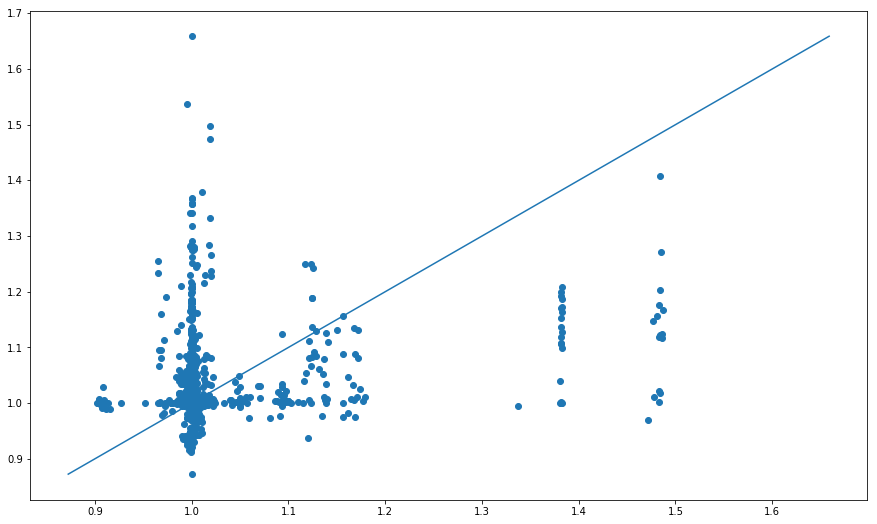

In [25]:
y_pred = clf.predict(x_test)
#for yt, yp in sorted(list(zip(y_test, y_pred)), key=lambda q: q[0]):
#    print(round(yt, 2), '\t', round(yp, 2))
    
plt.scatter(y_test, y_pred)
minv = min(min(y_test), min(y_pred))
maxv = max(max(y_test), max(y_pred))
plt.plot([minv, maxv], [minv, maxv])

In [7]:
if x.shape[1] != 2:
    pca = PCA(n_components=2)
    x2 = pca.fit_transform(x)
        
groups = list(df.index.get_level_values(0))
labels = [q[-6:] for q in groups]

trace1 = go.Scatter(x=x2[:,0], y=x2[:,1], mode='markers', text=labels, hoverinfo='text',
                        marker = dict(size=8, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False, hovermode='closest',
               yaxis=dict(zeroline=False, title='dim2'),
               xaxis=dict(zeroline=False, title='dim1'))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [13]:
fl = FileLoader(['o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'o9', 'o0'], mode='u', dim=[1, 2])
scores = []

for i in range(40):
    if (i+1)%10 == 0:
        print(i+1)
    fl.split()
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(fl.x_train, fl.y_train) 
    scores.append(clf.score(fl.x_test, fl.y_test))
    
print(round(np.mean(scores), 2), '+/-', round(np.std(scores), 2))

Loaded dataframe: (2157, 53)
Loaded dataframe: (2158, 1)
Train: (377, 56)
Test:  (171, 56)
Train: (385, 56)
Test:  (163, 56)
Train: (376, 56)
Test:  (172, 56)
Train: (378, 56)
Test:  (170, 56)
Train: (387, 56)
Test:  (161, 56)
Train: (380, 56)
Test:  (168, 56)
Train: (380, 56)
Test:  (168, 56)
Train: (385, 56)
Test:  (163, 56)
Train: (387, 56)
Test:  (161, 56)
10
Train: (379, 56)
Test:  (169, 56)
Train: (381, 56)
Test:  (167, 56)
Train: (385, 56)
Test:  (163, 56)
Train: (385, 56)
Test:  (163, 56)
Train: (385, 56)
Test:  (163, 56)
Train: (378, 56)
Test:  (170, 56)
Train: (392, 56)
Test:  (156, 56)
Train: (381, 56)
Test:  (167, 56)
Train: (380, 56)
Test:  (168, 56)
Train: (370, 56)
Test:  (178, 56)
20
Train: (373, 56)
Test:  (175, 56)
Train: (381, 56)
Test:  (167, 56)
Train: (390, 56)
Test:  (158, 56)
Train: (380, 56)
Test:  (168, 56)
Train: (386, 56)
Test:  (162, 56)
Train: (395, 56)
Test:  (153, 56)
Train: (373, 56)
Test:  (175, 56)
Train: (386, 56)
Test:  (162, 56)
Train: (387, 56)
Te

In [10]:
fl = FileLoader(['o3c'], mode='u', dim=[1, 2])
scores = []

for i in range(40):
    if (i+1)%10 == 0:
        print(i+1)
    fl.split()
    
    fs = FeatureSelector('pca')
    fs.fit(fl.x_train, fl.y_train, fl.df_train, pca_comp=11)
    x = fs.transform(fl.x_train)
    x_test = fs.transform(fl.x_test)
    y, y_test = fl.y_train, fl.y_test
    df, df_test = fl.df_train, fl.df_test
    
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(x, y) 
    scores.append(clf.score(x_test, y_test))
    
print(round(np.mean(scores), 2), '+/-', round(np.std(scores), 2))

Loaded dataframe: (13156, 53)
Loaded dataframe: (13157, 1)
Train: (6755, 56)
Test:  (2999, 56)
Train: (6836, 56)
Test:  (2918, 56)
Train: (6877, 56)
Test:  (2877, 56)
Train: (6833, 56)
Test:  (2921, 56)
Train: (6781, 56)
Test:  (2973, 56)
Train: (6819, 56)
Test:  (2935, 56)
Train: (6840, 56)
Test:  (2914, 56)
Train: (6874, 56)
Test:  (2880, 56)
Train: (6838, 56)
Test:  (2916, 56)
10
Train: (6809, 56)
Test:  (2945, 56)
Train: (6773, 56)
Test:  (2981, 56)
Train: (6797, 56)
Test:  (2957, 56)
Train: (6856, 56)
Test:  (2898, 56)
Train: (6852, 56)
Test:  (2902, 56)
Train: (6821, 56)
Test:  (2933, 56)
Train: (6874, 56)
Test:  (2880, 56)
Train: (6864, 56)
Test:  (2890, 56)
Train: (6830, 56)
Test:  (2924, 56)
Train: (6790, 56)
Test:  (2964, 56)
20
Train: (6844, 56)
Test:  (2910, 56)
Train: (6819, 56)
Test:  (2935, 56)
Train: (6803, 56)
Test:  (2951, 56)
Train: (6869, 56)
Test:  (2885, 56)
Train: (6818, 56)
Test:  (2936, 56)
Train: (6836, 56)
Test:  (2918, 56)
Train: (6853, 56)
Test:  (2901, 56)

In [ ]:
fl = FileLoader(['o1c'], mode='speedup', dim=[1, 2])
scores = []

for i in range(40):
    if (i+1)%10 == 0:
        print(i+1)
    fl.split()
    
    fs = FeatureSelector('nca')
    fs.fit(fl.x_train, fl.y_train, fl.df_train, nca_dim=16)
    x = fs.transform(fl.x_train)
    x_test = fs.transform(fl.x_test)
    y, y_test = fl.y_train, fl.y_test
    df, df_test = fl.df_train, fl.df_test
    
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(x, y) 
    scores.append(clf.score(x_test, y_test))
    
print(round(np.mean(scores), 2), '+/-', round(np.std(scores), 2))

Loaded dataframe: (10630, 53)
Loaded dataframe: (10629, 1)
   0 -3175.960816
   1 -3188.366689
   2 -3211.896278
   3 -3263.084757
   4 -3327.654113
   5 -3387.862917
   6 -3423.353179
   7 -3452.158065
   8 -3483.276954
   9 -3511.312155


In [16]:
res = {}
for c in df.columns:
    res[c] = 0

for i in range(40):
    fs = FeatureSelector('step')
    fs.fit(fl.x, fl.y, fl.df)
    x = fs.transform(fl.x)
    x_test = fs.transform(fl.x_test)
    feats = [fl.df.columns[q] for q in fs.feats]
    for f in feats:
        res[f] += 1
        
resl = [(k, v) for k, v in res.items()]
resl = sorted(resl, key=lambda q: q[1], reverse=True)
for k, v in resl:
    print(k, '\t', v)

Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.58
Selected 8 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L1_TCM
	PAPI_L2_DCM
	PAPI_L2_STM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.6
Selected 17 features:
	PAPI_BR_INS
	PAPI_DP_OPS
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_HW_INT
	PAPI_L1_STM
	PAPI_L2_DCM
	PAPI_L2_DCW
	PAPI_L2_LDM
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.54
Selected 10 features:
	PAPI_FDV_INS
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_SP_OPS
	PAPI_TLB_DM
	PAPI_TOT_CYC
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.5
Selected 15 features:
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_FP_INS
	P

Best score in training set: 0.6
Selected 7 features:
	PAPI_DP_OPS
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_L2_DCW
	PAPI_TLB_DM
	PAPI_TOT_IIS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.57
Selected 10 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_L2_DCM
	PAPI_L2_STM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
	PAPI_TLB_IM
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.57
Selected 11 features:
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_L2_DCM
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
	PAPI_TOT_IIS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.51
Selected 8 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L2_DCR
	PAPI_L2_DCW
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_LD_INS
	PAPI_SP_OPS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.

Best score in training set: 0.51
Selected 12 features:
	PAPI_CA_SHR
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_L1_DCH
	PAPI_L2_DCM
	PAPI_L2_TCA
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_SR_INS
	PAPI_TLB_DM
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.49
Selected 9 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L1_TCM
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_LD_INS
	PAPI_TOT_CYC
	PAPI_VEC_INS
	PAPI_VEC_SP
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.55
Selected 9 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L1_TCA
	PAPI_L2_DCW
	PAPI_L2_TCM
	PAPI_L2_TCW
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_TOT_IIS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.5
Selected 9 features:
	PAPI_FDV_INS
	PAPI_FP_OPS
	PAPI_L1_ICM
	PAPI_L1_STM
	PAPI_L2_DCA
	PAPI_L2_STM
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iterati

Best score in training set: 0.51
Selected 8 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_L2_DCR
	PAPI_L2_DCW
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_LD_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.51
Selected 12 features:
	PAPI_BR_INS
	PAPI_CA_SHR
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_L1_DCM
	PAPI_L1_ICA
	PAPI_L1_STM
	PAPI_L1_TCM
	PAPI_L2_DCM
	PAPI_LD_INS
	PAPI_REF_CYC
	PAPI_SP_OPS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.57
Selected 10 features:
	PAPI_BR_INS
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_L1_ICM
	PAPI_L1_TCM
	PAPI_L2_DCA
	PAPI_L2_DCM
	PAPI_L2_LDM
	PAPI_LD_INS
	PAPI_SP_OPS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.49
Selected 12 features:
	PAPI_BR_NTK
	PAPI_DP_OPS
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_L1_DCH
	PAPI_L2_TCH
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_TLB_DM
	PAPI_TOT_IIS
	PAPI_VEC_INS
Performing step fea

In [294]:
if x.shape[1] != 3:
    pca = PCA(n_components=3)
    x2 = pca.fit_transform(x)
        
trace1 = go.Scatter3d(x=x2[:,0], y=x2[:,1], z=x2[:,2], mode='markers', hoverinfo='none',
                        marker = dict(size=2, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False,
               yaxis=dict(zeroline=False, title='dim2', ticks='', showticklabels=False),
               xaxis=dict(zeroline=False, title='dim1', ticks='', showticklabels=False))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [9]:
model_path = '../lore/models/'
joblib.dump(scaler, model_path + 'scaler.pkl') 
joblib.dump(pca, model_path + 'pca.pkl')
joblib.dump(neigh, model_path + 'neigh.pkl') 

['../lore/models/neigh.pkl']

In [77]:
for q1, q2, q3 in zip(df['PAPI_L1_STM'], df['PAPI_L2_DCW'], df['PAPI_L2_TCW']):
    if q1 != q2 or q1 != q3:
        print(q1, q2, q3)
#fl.df.iloc[3]
#fl.df[['PAPI_L2_TCH', 'PAPI_L2_TCA']]

4.153637698261299 4.153637698261299


In [103]:
q=61
for c1 in fl.df.columns:
    for c2 in fl.df.columns:
        if c1 > c2 and fl.df[c1][q] != 0 and fl.df[c1][q] == fl.df[c2][q]:
            print(c1, fl.df[c1][q], c2, fl.df[c2][q])

PAPI_L2_DCR 0.0032231022340352663 PAPI_L1_LDM 0.0032231022340352663
PAPI_L2_DCW 1.0205804134654721e-08 PAPI_L1_STM 1.0205804134654721e-08
PAPI_L2_TCW 1.0205804134654721e-08 PAPI_L1_STM 1.0205804134654721e-08
PAPI_L2_TCW 1.0205804134654721e-08 PAPI_L2_DCW 1.0205804134654721e-08
max_dim 1 PAPI_TOT_INS 1


In [102]:
print(df['PAPI_L2_ICM'].sum(), df['PAPI_L1_STM'].sum())

8.186841109397044e-05 4.153637698261299


In [24]:
fl.x_test.shape

(17, 54)